In [1]:
import numpy as np
import xgboost as xgb
import art
import matplotlib.pyplot as plt
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack, HopSkipJump, BoundaryAttack
from art.utils import load_mnist
from pygoko import CoverTree, PyBayesCategoricalTracker

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
x_test = x_test
y_test = y_test
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))
dtrain = xgb.DMatrix(x_train, label=np.argmax(y_train, axis=1))
dtest = xgb.DMatrix(x_test, label=np.argmax(y_test, axis=1))
evals = [(dtest, "test"), (dtrain, "train")]
params = {"objective": "multi:softprob", "metric": "accuracy", "num_class": 10}
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=2, evals=evals)

[17:32:28] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-mlogloss:1.36772	train-mlogloss:1.35689
[1]	test-mlogloss:1.04625	train-mlogloss:1.02601


In [2]:
tree = CoverTree()
tree.set_leaf_cutoff(10)
tree.set_scale_base(1.3)
tree.set_min_res_index(-20)
tree.fit(x_train.astype(np.float32))

In [41]:
from typing import Optional, Tuple, Any
class KLDivTracker(art.defences.preprocessor.preprocessor.Preprocessor):
    params = ["tracker", "sample_rate", "stats", "query_count"]

    def __init__(
        self,
        tracker: PyBayesCategoricalTracker,
        sample_rate: int = 1,
    ) -> None:
        super().__init__(is_fitted=True, apply_fit=False, apply_predict=True)
        self.tracker = tracker
        self.sample_rate = sample_rate
        self.stats = []
        self.query_count = 0
    def __call__(self, x: np.ndarray, y: Optional[np.ndarray] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        if len(x.shape) == 1:
            self.tracker.push(x.flatten().astype(np.float32))
            if self.query_count % self.sample_rate == 0:
                self.stats.append(self.tracker.overall_aic())
            self.query_count += 1
        else:
            x_len = x.shape[0]
            x_flat = x.reshape((x_len,-1)).astype(np.float32)
            for point in x_flat:
                self.tracker.push(point)
                if self.query_count % self.sample_rate == 0:
                    self.stats.append(self.tracker.overall_aic())
                self.query_count += 1
        return (x,y)

    def forward(self, x: Any, y: Any = None) -> Tuple[Any, Any]:
        return (x,y)

ben_run_tracker = KLDivTracker(tree.kl_div_dirichlet(200),1)
benign_classifier = XGBoostClassifier(
    model=model, clip_values=(min_pixel_value, max_pixel_value), nb_features=28 * 28, nb_classes=10, preprocessing_defences = [ben_run_tracker]
)
malicious_predictor = XGBoostClassifier(
    model=model, clip_values=(min_pixel_value, max_pixel_value), nb_features=28 * 28, nb_classes=10, preprocessing_defences = None
)

In [42]:
zoo_run_tracker = KLDivTracker(tree.kl_div_dirichlet(200),1)
zoo_classifier = XGBoostClassifier(
    model=model, clip_values=(min_pixel_value, max_pixel_value), nb_features=28 * 28, nb_classes=10, preprocessing_defences = [zoo_run_tracker]
)

zoo_attack = ZooAttack(classifier=zoo_classifier)
permute = np.random.choice(len(x_test), 1)

x_test_adv = zoo_attack.generate(x=x_test[permute], y=y_test[permute])
predictions = malicious_predictor.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[permute], axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

ZOO:   0%|          | 0/1 [00:00<?, ?it/s]


TypeError: 'float' object is not subscriptable

In [ ]:
hsj_run_tracker = KLDivTracker(tree.kl_div_dirichlet(200),1)
hsj_classifier = XGBoostClassifier(
    model=model, clip_values=(min_pixel_value, max_pixel_value), nb_features=28 * 28, nb_classes=10, preprocessing_defences = [hsj_run_tracker]
)

hsj_attack = HopSkipJump(classifier=hsj_classifier)

permute = np.random.choice(len(x_test), 1)

x_test_adv = hsj_attack.generate(x=x_test[permute], y=y_test[permute])
predictions = malicious_predictor.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[permute], axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

HopSkipJump: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

Accuracy on adversarial test examples: 0.0%


In [ ]:
bdry_run_tracker = KLDivTracker(tree.kl_div_dirichlet(200),1)
bdry_classifier = XGBoostClassifier(
    model=model, clip_values=(min_pixel_value, max_pixel_value), nb_features=28 * 28, nb_classes=10, preprocessing_defences = [bdry_run_tracker]
)

bdry_attack = BoundaryAttack(bdry_classifier)

permute = np.random.choice(len(x_test), 1)

x_test_adv = bdry_attack.generate(x=x_test[permute], y=y_test[permute])
predictions = malicious_predictor.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[permute], axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 1321.04it/s]

Accuracy on adversarial test examples: 0.01%


In [ ]:
permute = np.random.choice(len(x_test), len(zoo_run_tracker.stats))
print(len(permute))
predictions = benign_classifier.predict(x_test[permute])
print(ben_run_tracker.query_count)
accuracy += np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[permute], axis=1))
print("Accuracy on benign test examples: {}%".format(accuracy*100 / len(permute)))

516
516
Accuracy on benign test examples: 90.89149224806201%


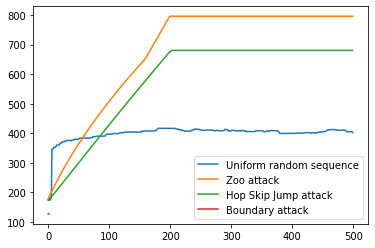

In [ ]:
l = len(ben_run_tracker.stats[0:500])
plt.plot(np.arange(len(ben_run_tracker.stats[0:l])),ben_run_tracker.stats[0:l], label = "Uniform random sequence")
plt.plot(np.arange(len(zoo_run_tracker.stats[0:l])),zoo_run_tracker.stats[0:l], label = "Zoo attack")
plt.plot(np.arange(len(hsj_run_tracker.stats[0:l])),hsj_run_tracker.stats[0:l], label = "Hop Skip Jump attack")
plt.plot(np.arange(len(bdry_run_tracker.stats[0:l])),bdry_run_tracker.stats[0:l], label = "Boundary attack")
plt.legend()
plt.show()